## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import moment
from collections import deque

# Pytorch
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import sklearn
from sklearn.metrics import mean_squared_error
import math
import plotly.express as px

import os
os.chdir("/home/rodrigo/mount/home/rodrigo/git/neural_kaggle_store_item")

import time
import math
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from transformer.model import TransformerTimeSeries
from transformer.utils import TransformerTimeSet, batch_train, batch_val
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
np.random.seed(0)


## Generate train and test sets
For a simple example lets generate sinusoid data to test with

In [2]:
data_train = pd.read_csv('train_series.csv')
data_train = data_train['data'].to_numpy()

data_val = pd.read_csv('val_series.csv')
data_val = data_val['data'].to_numpy()

total_train = len(data_train)

data_test = pd.read_csv('test_series.csv')
data_test = data_test['data'].to_numpy()

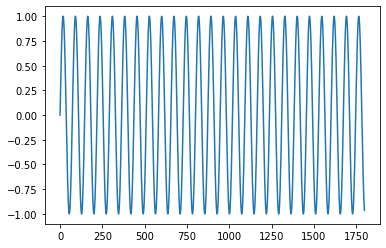

In [3]:
plt.plot(data_train)

## Using Neural networks for solving the time series problem
First, it is necessary to transform this time series problem into a supervised learning problem; for this, it is necessary to define whether the network will make a recursive forecast, in which the forecasts will be used as resources for a longer time horizon or if the network will make a direct forecast, in which the network only uses the last steps of time and resources known as the day of the week, to forecast several steps.

## Rolling window approach

With this approach is possible to turn a series of data into a supervised learning problem, this way the model can intepretate the problem properly.

In [4]:
#Scaling the entry data
data_train   = data_train.reshape(-1,1)
scaler       = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_train)
data_train   = scaler.transform(data_train).flatten()

index_val     = np.arange(len(data_train))

pred_horizon = 30
# The label window is equal to the size of decoder input and output
label_win = 60
dec_inp = 30

# The feat window is the size of the encoder input and output
feat_win  = 30
win_size  = label_win + feat_win 
n_windows = total_train - win_size


In [5]:
index_val

array([   0,    1,    2, ..., 1797, 1798, 1799])

In [6]:
def rolling_window(n_windows, feat_win, label_win, dataset):
    # encoder and decoder vectors
    x_encoder = np.zeros((n_windows, int(feat_win)))
    x_decoder = np.zeros((n_windows, int(label_win)))
    x_id_encoder = np.zeros((n_windows, int(feat_win)))
    x_id_decoder = np.zeros((n_windows, int(label_win)))

    # output
    y_train = np.zeros((n_windows, label_win))
    y_id = np.zeros((n_windows, label_win))
    for win in range(n_windows):
        # Feature window start and end index
        i_s_feat = win
        i_e_feat = i_s_feat + feat_win

        # Label window start and end index
        i_s_label = i_e_feat
        i_e_label = i_s_label + label_win

        # Geting the past sales feature
        x_encoder[win] = dataset[i_s_feat : i_e_feat]
        x_id_encoder[win] = index_val[i_s_feat : i_e_feat]

        # Treat the decoder as autoregressive
        # and use lagged labels in the training and predictions in test
        x_decoder[win][:dec_inp] = data_train[i_s_label: i_e_label][:pred_horizon]
        x_id_decoder[win] = index_val[i_s_label: i_e_label]

        # Geting the labels
        y_train[win] = data_train[i_s_label : i_e_label]
        y_id[win] = index_val[i_s_label : i_e_label]
        
    return x_encoder, x_decoder, x_id_encoder, x_id_decoder , y_train, y_id

In [7]:
x_encoder, x_decoder, x_id_encoder, x_id_decoder , y_train, y_id = rolling_window(n_windows, feat_win, 
                                                                  label_win, data_train)

n_val_windows = len(data_val) - win_size
x_val_encoder, x_val_decoder, _, _ , y_val, _ = rolling_window(n_val_windows, feat_win, 
                                                                  label_win, data_val)

In [8]:
y_id[0]

array([30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
       56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68.,
       69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81.,
       82., 83., 84., 85., 86., 87., 88., 89.])

In [9]:
x_id_encoder[0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.])

In [10]:
x_id_decoder[0]

array([30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
       56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68.,
       69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81.,
       82., 83., 84., 85., 86., 87., 88., 89.])

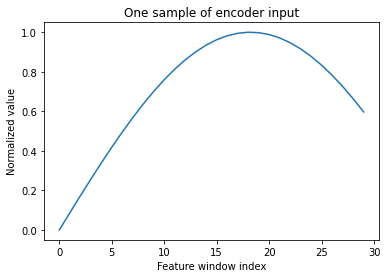

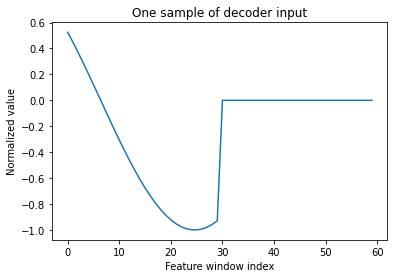

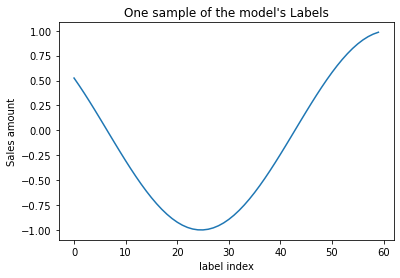

In [11]:
plt.plot(x_encoder[0], label='encoder input')
plt.ylabel('Normalized value')
plt.xlabel('Feature window index')
plt.title("One sample of encoder input")
plt.show()

plt.plot(x_decoder[0], label='decoder input')
plt.ylabel('Normalized value')
plt.xlabel('Feature window index')
plt.title("One sample of decoder input")
plt.show()

plt.plot(y_train[0], label='labels')
plt.ylabel('Sales amount')
plt.xlabel('label index')
plt.title("One sample of the model's Labels")
plt.show()


## Defining the model
The recommended neural network for a time series problem usualy is a LSTM, in this example peharps we will use a simple multi layer perceptron (MLP) model.

## Transformer network

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model = TransformerTimeSeries(device,  dropout=0, d_model=64, nhead=4,
                              decoder_mask=False, iterative=False,
                              n_encoder_time_steps=feat_win,
                              n_output_time_steps=label_win).to(device)

criterion = nn.MSELoss()
lr = 0.0005
batch_size= 60
epochs = 30
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

Using device: cuda


In [13]:
train_set = TransformerTimeSet(x_encoder, x_decoder, y_train, feat_win, label_win)
train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True)

val_set = TransformerTimeSet(x_val_encoder, x_val_decoder, y_val, feat_win, label_win)
val_loader = DataLoader(val_set,
                          batch_size=batch_size,
                          shuffle=True)

In [14]:
loss = []
val_loss = []
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    val_epoch_loss = batch_val(model, val_loader, criterion, device, 
                               informer_pred_sz=pred_horizon)
    epoch_loss = batch_train(model, epoch, batch_size, train_loader, criterion, optimizer, 
                             scheduler,  
                             y_train.shape[0], 
                             device,  
                             informer_pred_sz=pred_horizon)
    loss.append(epoch_loss)
    val_loss.append(val_epoch_loss)
    scheduler.step()


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |     5/   28 batches | lr 0.000500 | 67.28 ms | loss 0.85780
| epoch   1 |    10/   28 batches | lr 0.000500 | 56.49 ms | loss 0.43490
| epoch   1 |    15/   28 batches | lr 0.000500 | 45.41 ms | loss 0.35726
| epoch   1 |    20/   28 batches | lr 0.000500 | 56.11 ms | loss 0.29119
| epoch   1 |    25/   28 batches | lr 0.000500 | 46.78 ms | loss 0.22084
| epoch   2 |     5/   28 batches | lr 0.000480 | 54.20 ms | loss 0.15917
| epoch   2 |    10/   28 batches | lr 0.000480 | 39.44 ms | loss 0.08033
| epoch   2 |    15/   28 batches | lr 0.000480 | 40.44 ms | loss 0.02817
| epoch   2 |    20/   28 batches | lr 0.000480 | 40.78 ms | loss 0.01169
| epoch   2 |    25/   28 batches | lr 0.000480 | 41.45 ms | loss 0.01296
| epoch   3 |     5/   28 batches | lr 0.000471 | 73.31 ms | loss 0.00404
| epoch   3 |    10/   28 batches | lr 0.000471 | 67.84 ms | loss 0.00275
| epoch   3 |    15/   28 batches | lr 0.000471 | 62.57 ms | loss 0.00180
| epoch   3 |    20/   28 batches | lr

In [15]:
plot_df ={'epoch': np.arange(epoch),
          'train_loss': loss,
          'val_loss': val_loss,}

fig = px.line(plot_df, x='epoch', y=['train_loss', 'val_loss'])
fig.show()

## Testing iteratively

### Third test: Test with encoder vector full and decoder vector with only one sample

In [16]:
data_test   = data_test.reshape(-1,1)
data_test   = scaler.transform(data_test).flatten()

encoder_test = np.zeros(int(feat_win))
encoder_test = data_val[-(feat_win+pred_horizon):-pred_horizon]

decoder_test = np.zeros(int(label_win))
decoder_test[:pred_horizon] = data_val[-(pred_horizon):]

label_test = np.zeros(int(label_win))
label_test[:pred_horizon] = decoder_test[:pred_horizon]
label_test[pred_horizon:] = data_test[:pred_horizon]

In [17]:
np.array([encoder_test]).shape

(1, 30)

In [18]:
test_set  = TransformerTimeSet(np.array([encoder_test]), np.array([decoder_test]) ,
                                    np.array([label_test]),  feat_win, label_win)
test_loader = DataLoader(test_set,
                          batch_size=batch_size,
                          shuffle=False)

In [19]:
src, tgt_in, true_target = next(iter(test_loader))
src = Variable(torch.Tensor(src.float())).to(device)
tgt_in  = Variable(torch.Tensor(tgt_in.float())).to(device)
pred_iterative = np.zeros(feat_win)

In [20]:
src

tensor([[[-0.6044],
         [-0.5335],
         [-0.4586],
         [-0.3803],
         [-0.2992],
         [-0.2159],
         [-0.1309],
         [-0.0450],
         [ 0.0413],
         [ 0.1273],
         [ 0.2123],
         [ 0.2957],
         [ 0.3769],
         [ 0.4554],
         [ 0.5304],
         [ 0.6015],
         [ 0.6681],
         [ 0.7297],
         [ 0.7859],
         [ 0.8363],
         [ 0.8804],
         [ 0.9180],
         [ 0.9488],
         [ 0.9725],
         [ 0.9889],
         [ 0.9980],
         [ 0.9997],
         [ 0.9940],
         [ 0.9808],
         [ 0.9603]]], device='cuda:0')

In [21]:
tgt_in

tensor([[[ 0.9327],
         [ 0.8982],
         [ 0.8569],
         [ 0.8093],
         [ 0.7557],
         [ 0.6964],
         [ 0.6320],
         [ 0.5628],
         [ 0.4895],
         [ 0.4125],
         [ 0.3325],
         [ 0.2500],
         [ 0.1656],
         [ 0.0800],
         [-0.0062],
         [-0.0924],
         [-0.1778],
         [-0.2620],
         [-0.3442],
         [-0.4238],
         [-0.5003],
         [-0.5731],
         [-0.6416],
         [-0.7053],
         [-0.7638],
         [-0.8166],
         [-0.8633],
         [-0.9036],
         [-0.9371],
         [-0.9637],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],


In [22]:
total_pred  = model((src, tgt_in)).cpu().view(-1).detach().numpy()

### Store the predictions in a array

In [23]:
label_test = true_target.cpu().view(-1).detach().numpy()
label_test = label_test.reshape(len(label_test),1)
label_test = scaler.inverse_transform(label_test).flatten()
output = total_pred.reshape(-1,1)
output = scaler.inverse_transform(output).flatten()

In [24]:
label_test.shape

(60,)

In [25]:
plot_df ={'prediction_index': np.arange(pred_horizon),
          'pred': output[-pred_horizon:],
          'label': label_test[-pred_horizon:],
          'error': output[-pred_horizon:]-label_test[-pred_horizon:]}

fig = px.line(plot_df, x='prediction_index', y=['pred','label','error'])
fig.show()

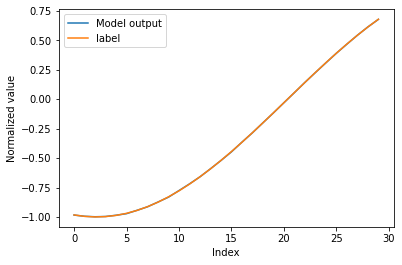

In [26]:
plt.plot(output[-pred_horizon:], label='Model output')
plt.plot(label_test[-pred_horizon:], label='label')


plt.ylabel('Normalized value')
plt.xlabel('Index')
plt.legend()
plt.show()

In [27]:
mean_squared_error(label_test[-pred_horizon:], output[-pred_horizon:])

1.6319086156042869e-06

## Check the attention values and shape

In [28]:
attention_weights = model.encoder_attention(src)[1]
attention_weights = attention_weights.cpu().detach().numpy()
attention_weights = attention_weights.reshape(src.shape[1], src.shape[1])

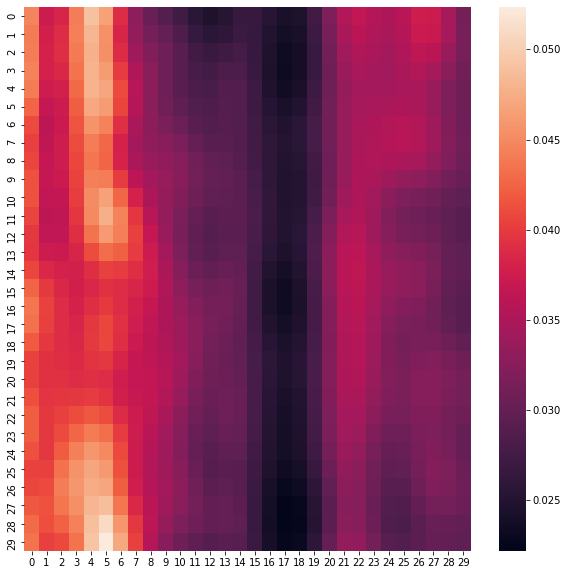

In [29]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(attention_weights)

In [30]:
df = {'row_idx':[],
      'col_idx':[],
      'value':[]}
for row_idx in range(attention_weights.shape[0]):
    for col_idx in range(attention_weights.shape[1]):
        df['row_idx'].append(row_idx)
        df['col_idx'].append(col_idx)
        df['value'].append(attention_weights[row_idx][col_idx])

<ipython-input-31-f4d206db1fe0>:11: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



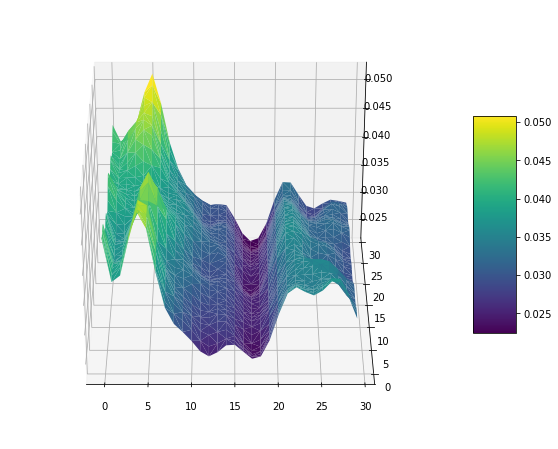

In [31]:
df = pd.DataFrame(df)
# Transform it to a long format
df.columns=["X","Y","Z"]
 
# And transform the old column name in something numeric
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes
 
# to Add a color bar which maps values to colors.
fig = plt.figure(figsize=(11, 8))
ax = fig.gca(projection='3d')
surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
ax.view_init(30, -90)
plt.show()

### Decoder attention

In [32]:
self_att,_ = model.decoder_attention((src, tgt_in))
attention_weights = self_att[1]
attention_weights = attention_weights.cpu().detach().numpy()

attention_weights.shape

(1, 60, 60)

In [33]:
attention_weights = attention_weights.reshape(tgt_in.shape[1], tgt_in.shape[1])

In [34]:
df = {'row_idx':[],
      'col_idx':[],
      'value':[]}
for row_idx in range(attention_weights.shape[0]):
    for col_idx in range(attention_weights.shape[1]):
        df['row_idx'].append(row_idx)
        df['col_idx'].append(col_idx)
        df['value'].append(attention_weights[row_idx][col_idx])

<ipython-input-35-f4d206db1fe0>:11: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



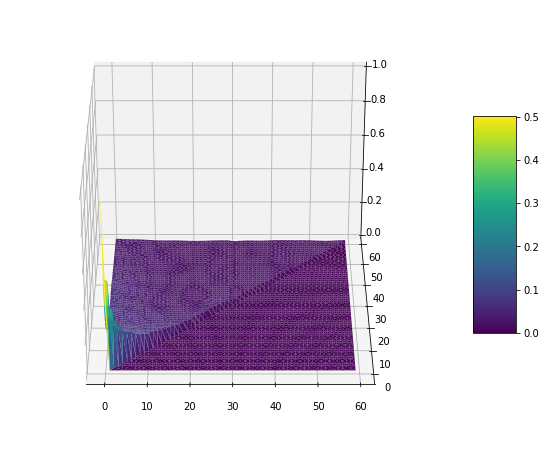

In [35]:
df = pd.DataFrame(df)
# Transform it to a long format
df.columns=["X","Y","Z"]
 
# And transform the old column name in something numeric
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes
 
# to Add a color bar which maps values to colors.
fig = plt.figure(figsize=(11, 8))
ax = fig.gca(projection='3d')
surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
ax.view_init(30, -90)
plt.show()

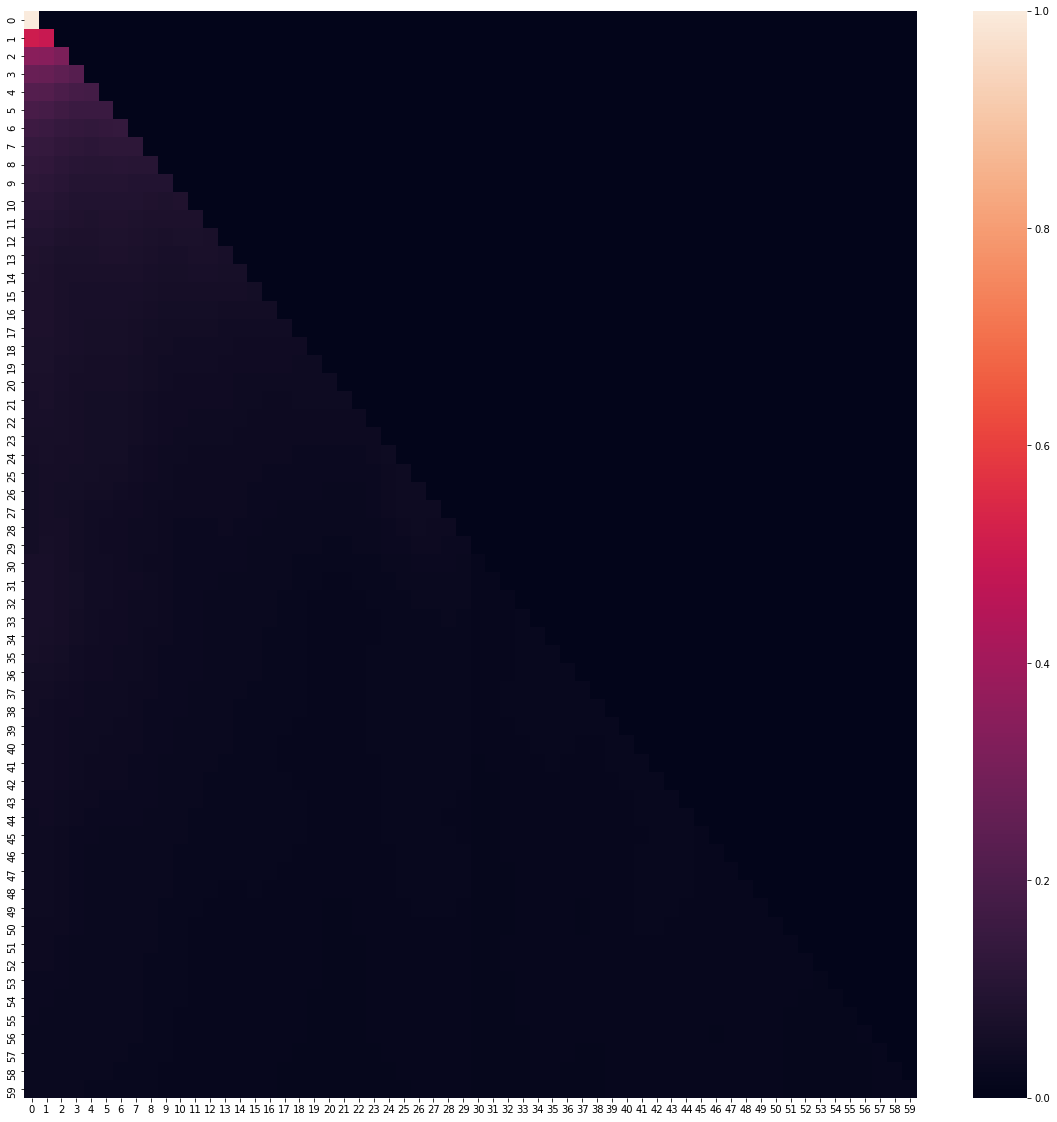

In [36]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(attention_weights)